In [16]:
from core.DataLoader import *
from core.models.MLP import * 
from core.models.GAM import *
from core.models.SVM import *
# from core.models.EBM import *

from core.models.RandomForest import *
from core.Visualizer import *
from core.models.Classifier import *
from core.models.XGB import *

In [17]:
model_accs = {
    'MLP': [],
    'RF(5)': [],
    'RF(10)': [],
    'RF(U)': [],
    'DT(5)': [],
    'DT(10)': [],
    'DT(U)': [],
    'LR': [],
    'SVM': [],
    'XGB': []
}
# present_idxs = [0, 1, 2, 3, 4, 5, 8 ,12, 21, 22, 23, 24]
# present_idxs = [0,10]
present_idxs = [0, 1, 2, 3]

In [18]:
weighted_clf_model_list ={
    "MLP": MLPClassifier,
    "DT": m_DecisionTreeClassifier,
    "RF": m_RandomForestClassifier,
    "LR": m_LogisticRegression,
    "SVM": SVMClassifier,
    "XGB": XGBOOSTClassifier
}
# weighted_clf_model_name_list = ['MLP', 'RF(5)', 'RF(10)', 'RF(U)', 'DT(5)', 'DT(10)', 'DT(U)', 'LR', 'SVM', 'XGB']
weighted_clf_model_name_list = ['MLP']

In [32]:
engine = 'mssql'
dl = DataLoader(engine)
# one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'imdb'])
one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'imdb'], suffix='(random_left)')
present_idxs = list(range(len(one_file_dss)))

In [33]:
key_features = [['sel_of_pred_on_indexed_attr', 'left_cardinality'], 
                ['sel_of_pred_on_indexed_attr_and_join_pred', 'left_cardinality'],
               ['sel_of_pred_on_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr'],
               ['sel_of_pred_on_indexed_attr_and_join_pred', 'result_size']]

# if engine == 'mssql':
#     key_features = ['sel_of_pred_on_indexed_attr_and_join_pred', 'left_cardinality']
# else:
#     key_features = ['sel_of_pred_on_indexed_attr', 'left_cardinality']
    
classification_target = dl.classification_target

key_feature_set = 0
features = key_features[key_feature_set]
print("Using features: ", features)

Using features:  ['sel_of_pred_on_indexed_attr', 'left_cardinality']


100%|██████████| 500/500 [00:51<00:00,  9.76it/s]


ssb part/mssql_lineorder_part_optimal.csv
Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625


<Figure size 432x288 with 0 Axes>

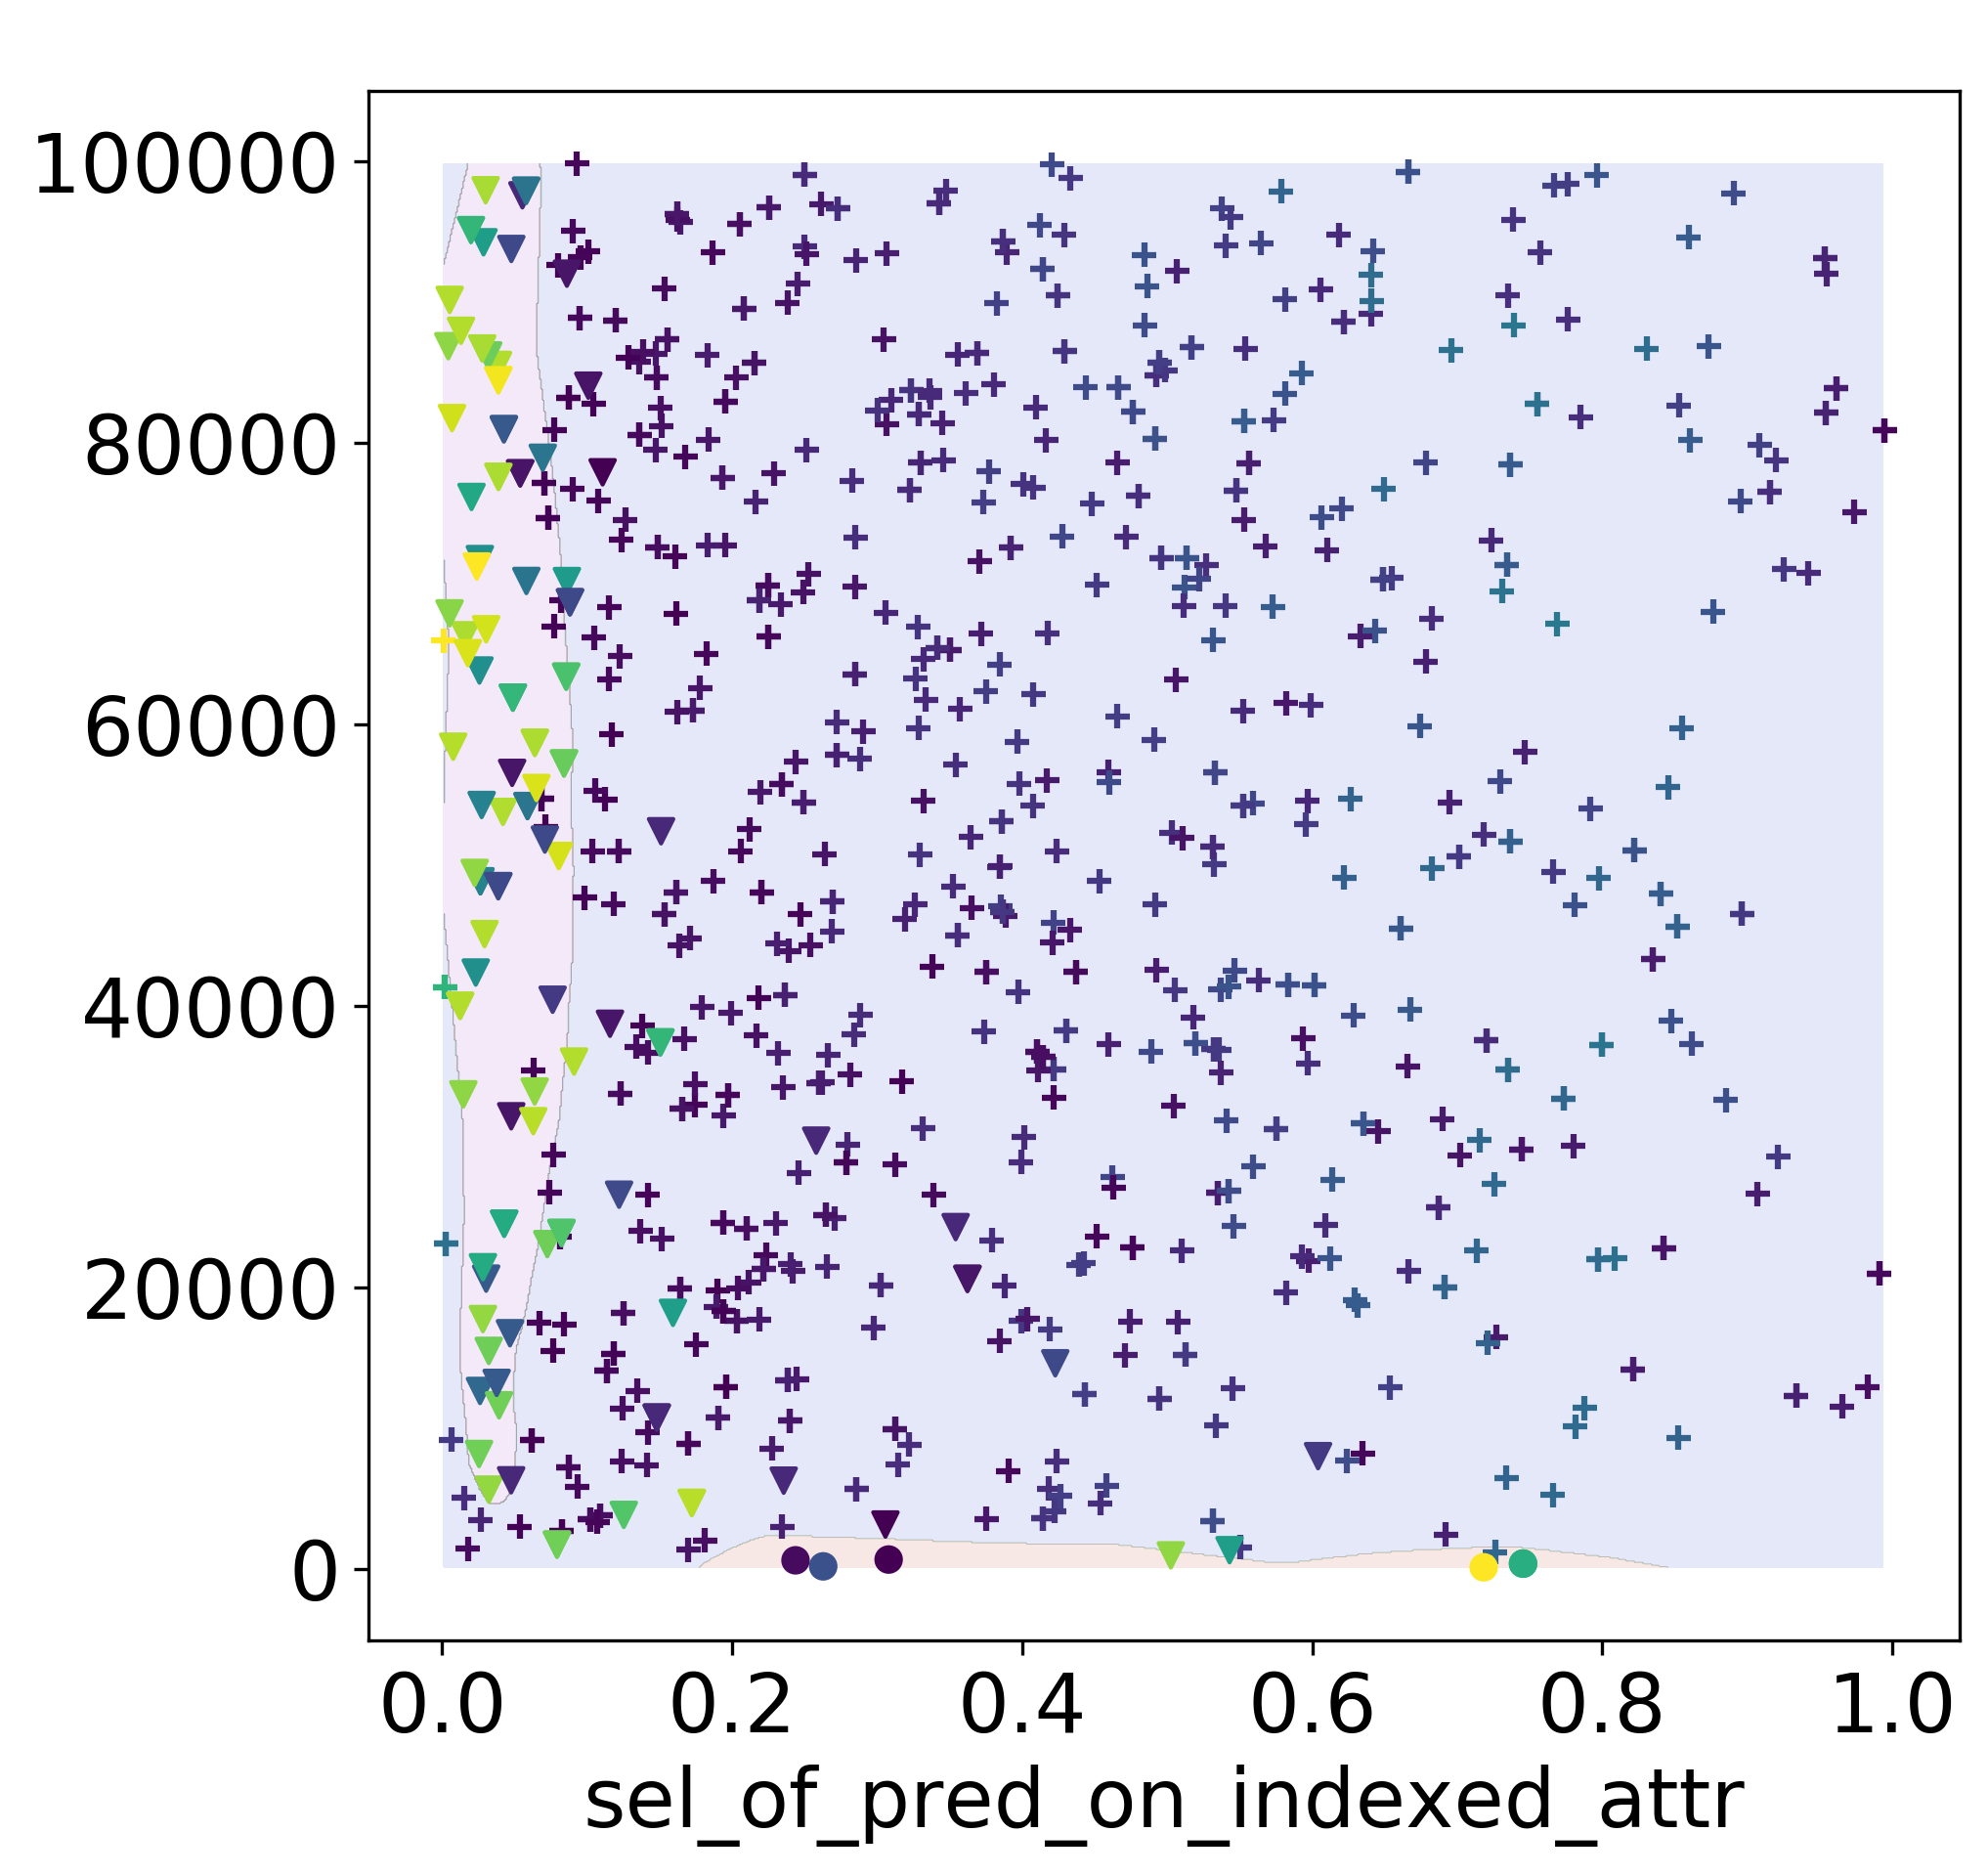

In [54]:
# model_perf = {
    
# }

for i in [0]:  # range(len(one_file_dss)):
#     i = 0
    # ds = one_file_dss[i][one_file_dss[i]['predicate_op_num_on_non_indexed_attr'] == 0]
    ds = one_file_dss[i]
    ds_name = one_file_names[i]
    
#     ds = ds.iloc[0:1000]
    
    # =========================
    X = ds[features]
    y = ds['optimal_decision']
    X_costs = ds[dl.regression_targets]

    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
    X_train_costs, X_test_costs, _, _, = train_test_split(X_costs, y, train_size=0.8, random_state=1)
    X_train, X_test, y_train, y_test = \
        X_train.to_numpy(),X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

    X_train_weights = calculate_importance_from_costs(X_train_costs.to_numpy())

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # scaler = preprocessing.StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)

    X_train_weights = preprocessing.MinMaxScaler().fit_transform(X_train_weights.reshape(-1,1)).flatten()
    # =========================
    
    accs = []
    for idx, model_name in enumerate(weighted_clf_model_name_list):
        model = weighted_clf_model_list[model_name.split('(')[0]]        
        if 'DT' in model_name or 'RF' in model_name:
            max_depth = model_name.split('(')[-1].split(')')[0]
            if max_depth.lower() == 'u':
                max_depth = None
            else:
                max_depth = int(max_depth)
            clf = model().fit(X_train, y_train, sample_weight=X_train_weights, max_depth=max_depth)
        else:
            clf = model().fit(X_train, y_train, sample_weight=X_train_weights, max_iter=500, weight_decay=0.000001)
        print(one_file_names[i])
        print(f"Accuray of {model}: {clf.score(X_test, y_test)}")
        
        # =================================
        # Average misprediction cost
#         test_predictions = clf.predict(X_test)
#         error_costs = []
#         X_test_costs = X_test_costs.to_numpy()
#         # print(test_predictions)
#         for test_id in range(len(test_predictions)):
#             if test_predictions[test_id] != y_test[test_id]:
#                 error_costs.append(X_test_costs[test_id, test_predictions[test_id]] - X_test_costs[test_id, y_test[test_id]])
#         print(f"Misprediction Costs: \nmin: {np.min(error_costs)}; max: {np.max(error_costs)}; median:{np.median(error_costs)}; avg: {np.average(error_costs)}")
        # =================================
        
        if len(features) == 2:
            x_label = features[0] # sel_on_indexed_attr'
            y_label = features[-1]
            if i == 0 and engine=='postgres':
                y_label = 'left_cardinality' # features[-1]
            else:
                y_label = None
            if i == 1 and engine == 'mssql':
                colorbar = False
            else:
                colorbar = False
            plot_2d_decision_boundaries(clf, scaler.inverse_transform(X_train[0:800, :]), X_train_costs.to_numpy()[0:800, :], y_train[0:800], title=f' ', 
                                        x_label=x_label, y_label=y_label, scaler=scaler, 
                                        filename=f'./figures/exp2-viz-decision-space-{engine}-(random_left)-{i}', plot_colorbar=colorbar)
#             plot_2d_decision_boundaries(clf, scaler.inverse_transform(X_train[0:800, :]), X_train_costs.to_numpy()[0:800, :], y_train[0:800], title=f' ', 
#                                         x_label=x_label, y_label=y_label, scaler=scaler, 
#                                         filename=f'./figures/exp2-viz-decision-space-{engine}-{i}', plot_colorbar=colorbar)
        
        
        model_accs[model_name].append(clf.score(X_test, y_test))
#         accs.append(clf.score(X_test, y_test))
        
    
#     model_perf[ds_name] = accs
#     break
    

In [21]:
# def export_legend(legend, filename="legend.png"):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [8]:
# from matplotlib.lines import Line2D
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42


# plt.figure(figsize=(10,10), dpi=300)



# custom_lines = [Line2D([0], [0], color='b', lw=10, alpha=0.1),
#                 Line2D([0], [0], color='g', lw=10, alpha=0.1),
#                 Line2D([0], [0], color='r', lw=10, alpha=0.1),
#                 Line2D([0], [0], color='c', lw=10, alpha=0.1),
#                 Line2D([0], [0], color='m', lw=10, alpha=0.1),
#                 Line2D([0], [0], color='y', lw=10, alpha=0.1)]

# # fig, ax = plt.subplots()
# # lines = ax.plot(data)
# plt.legend(custom_lines, ['hash join + index scan', 'hash join + seq scan', 'nested loop + index scan', 
#                          'nested loop + seq scan', 'merge join + index scan', 'merge join + seq scan'])

# export_legend(plt.legend(custom_lines, ['hash join + index scan', 'hash join + seq scan', 'nested loop + index scan', 
#                          'nested loop + seq scan', 'merge join + index scan', 'merge join + seq scan'], fontsize=15, framealpha=1, frameon=True), './figures/exp2-viz-contour-legend.pdf')
# plt.show()